# Plot how distance between song-driven MA trajectories changes over time

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 50
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p, adapt='MA'):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        if adapt == 'MA':
            vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        elif adapt == 'lin':
            vs[ct, :] = x_s*(i_s[ct]-a_ss[ct-1, :]) + x_p*(i_p[ct]-a_ps[ct-1, :])
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [6]:
# get snippets
T_SNP = 300
MIN_GAP = np.inf

# save some example snippets and responses

sys.stdout.write(f'T_SNP {T_SNP}: ')

NT_SNP = int(round(T_SNP*FPS))
t_snp = np.arange(NT_SNP)*DT

snps_all = []

for csng, sng_full in enumerate(sngs_full):

    segs, bds = get_seg(sng_full > 0, min_gap=MIN_GAP)
    segs = [sng_full[lb:ub] for lb, ub in bds]

    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:NT_SNP] for seg in segs if (len(seg) >= NT_SNP)]

    snps_all.extend(segs)

snps_scrambled_all = [snp[np.random.permutation(len(snp))] for snp in snps_all]

snps_all = np.array(snps_all)
nsnp = len(snps_all)

snps_scrambled_all = np.array(snps_scrambled_all)

sys.stdout.write(f'{nsnp} snippets')

rs_all = []
rs_all_scrambled = []

for snp, snp_scrambled in zip(snps_all, snps_scrambled_all):
    sys.stdout.write('.')
    rs = smlt(snp==1, snp==2, tau_r, tau_a, x_p, x_s, adapt='MA')[0]
    rs_scrambled = smlt(snp_scrambled==1, snp_scrambled==2, tau_r, tau_a, x_p, x_s, adapt='MA')[0]
    
    rs_all.append(rs.copy())
    rs_all_scrambled.append(rs_scrambled.copy())

T_SNP 300: 57 snippets.........................................................

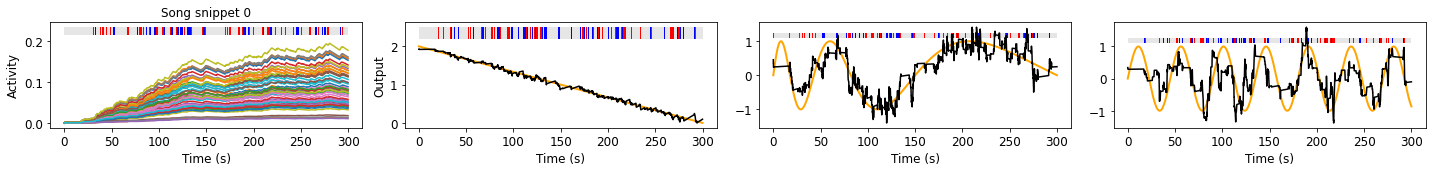

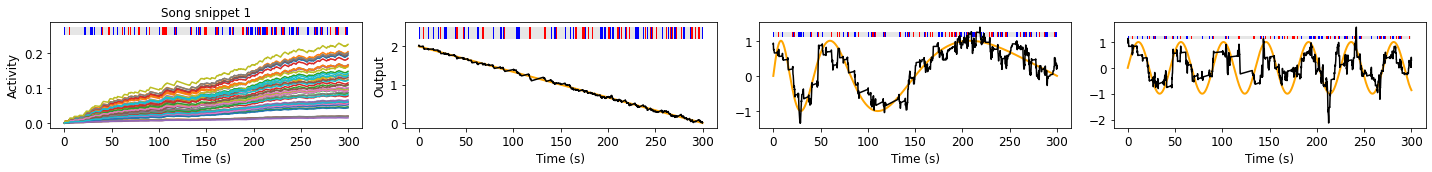

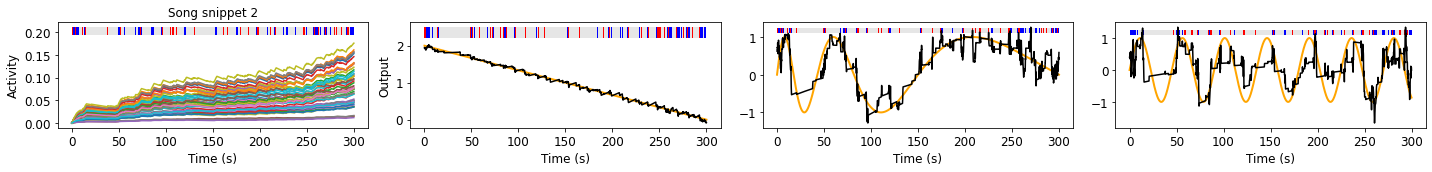

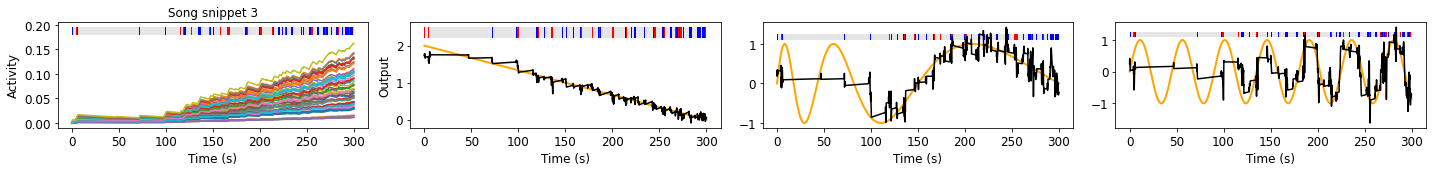

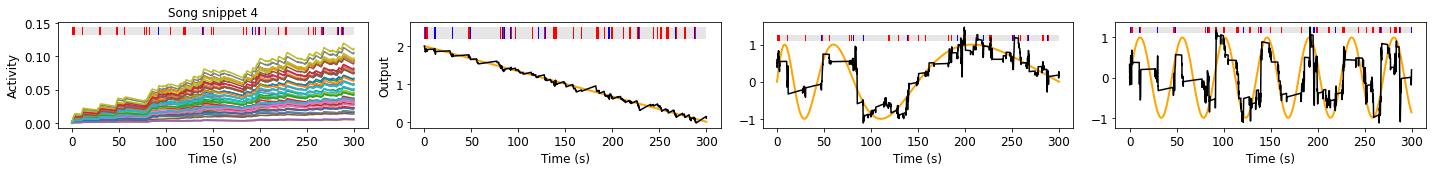

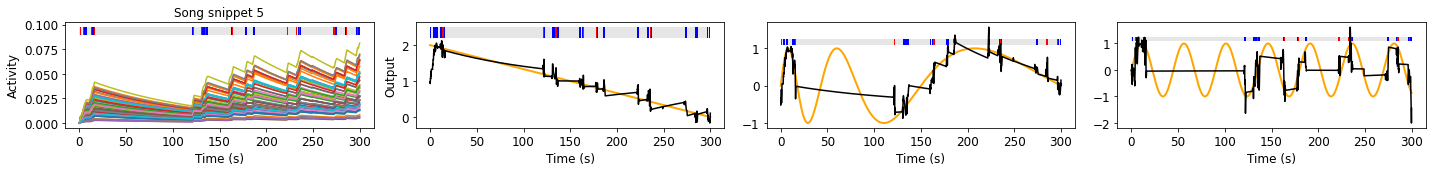

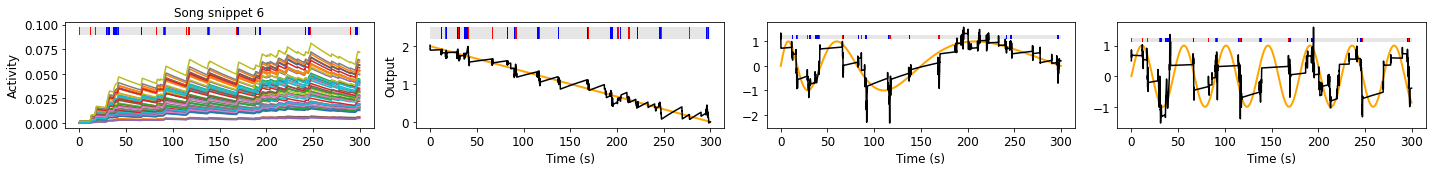

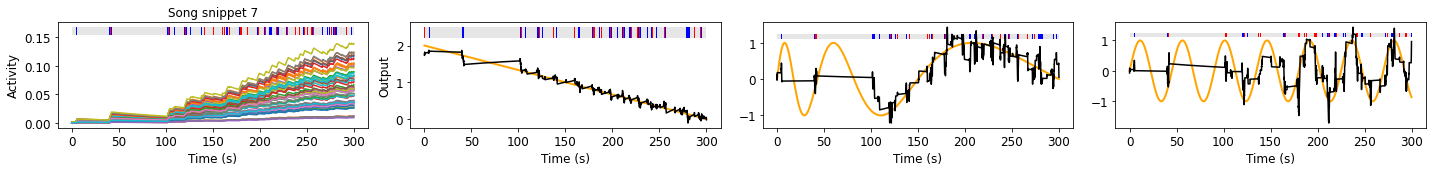

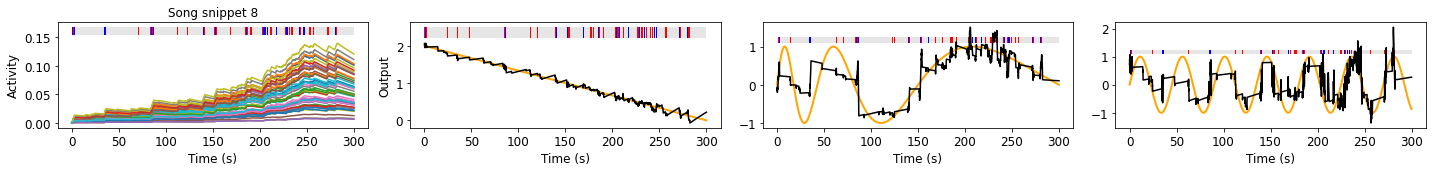

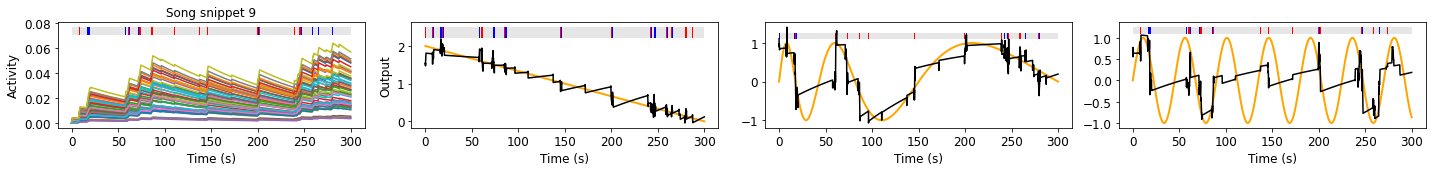

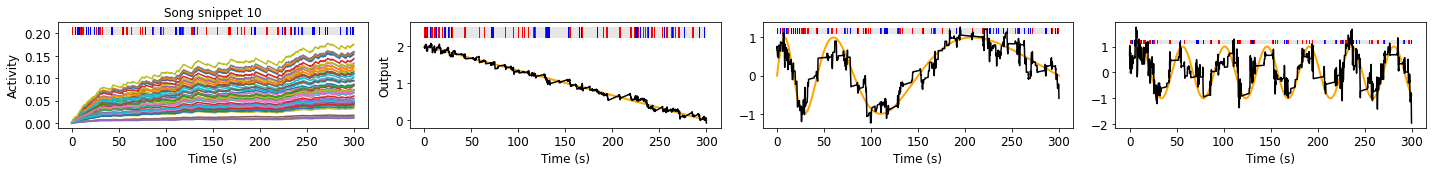

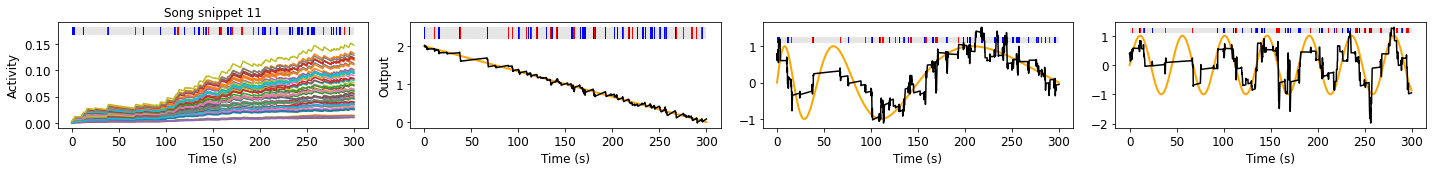

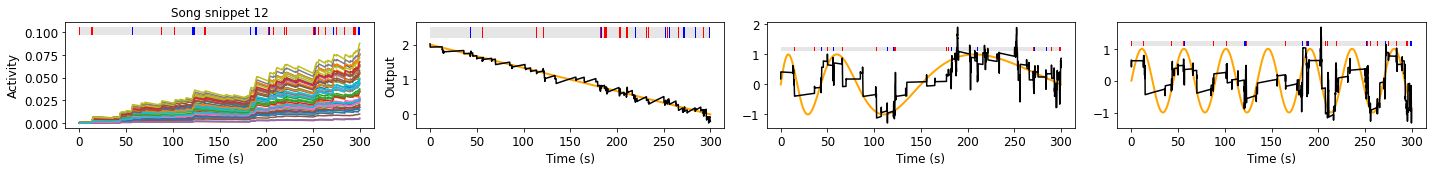

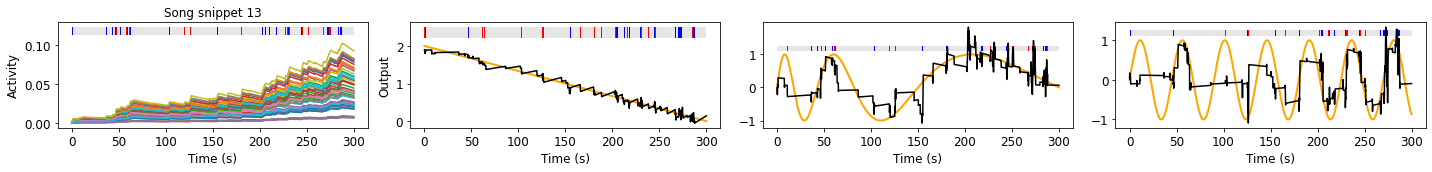

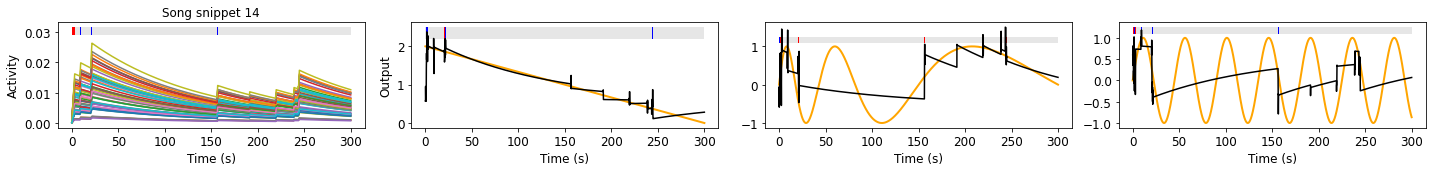

In [7]:
ALPHA = 1e-15
NSNP_TEST = 15

t = np.arange(len(rs_all[0]))*DT

ys = [
    2*(t.max() - t.copy())/t.max(),
    np.sin(2*np.pi*t/np.linspace(30, 120, len(t))),
    np.sin(2*np.pi*t/45),
]

for csnp, (snp, rs) in enumerate(zip(snps_all[:NSNP_TEST], rs_all[:NSNP_TEST])):

    fig, axs = plt.subplots(1, len(ys)+1, figsize=(20, 2.5), tight_layout=True, sharex=True)
    axs[0].plot(t, rs)
    plot_b(axs[0], t, snp, [0, t.max(), 1.1*rs.max(), 1.2*rs.max()], [(.9, .9, .9), 'b', 'r'])
    set_plot(axs[0], x_label='Time (s)', y_label='Activity', title=f'Song snippet {csnp}')

    for ax, y in zip(axs[1:], ys):
        rgr = linear_model.Ridge(alpha=ALPHA)
        rgr.fit(rs, y)
        y_hat = rgr.predict(rs)

        ax.plot(t, y, c='orange', lw=2)
        ax.plot(t, y_hat, c='k')

        plot_b(ax, t, snp, [0, t.max(), 1.1*y.max(), 1.25*y.max()], [(.9, .9, .9), 'b', 'r'])

        set_plot(ax, x_label='Time (s)')
    
    set_plot(axs[1], y_label='Output')

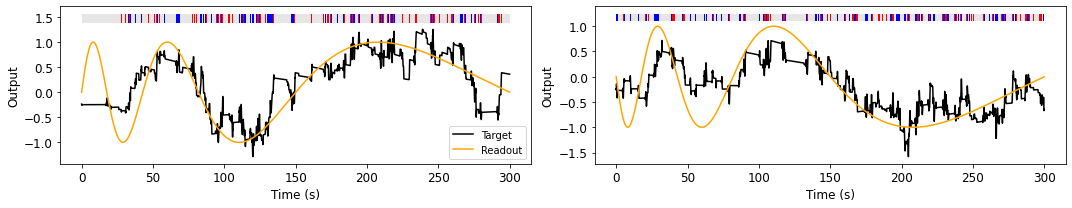

In [37]:
# map two snippets to two outputs
ALPHA = 1e-10

isnps = [0, 1]

# ys = [
#     2*(t.max() - t.copy())/t.max() - 1,
#     -2*(t.max() - t.copy())/t.max() + 1,
# ]

ys = [
    np.sin(2*np.pi*t/np.linspace(30, 120, len(t))),
    -np.sin(2*np.pi*t/np.linspace(30, 120, len(t))),
]

snps = [snps_all[isnp] for isnp in isnps]
rs = [rs_all[isnp] for isnp in isnps]

## fit model
rgr = linear_model.Ridge(alpha=ALPHA)
rgr.fit(cc(rs), cc(ys))
# rgr.fit(cc(rs), cc(ys)[np.random.permutation(len(cc(ys)))])

y_hats = []

for rs_ in rs:
    y_hat = rgr.predict(rs_)
    y_hats.append(y_hat.copy())
    
fig, axs = plt.subplots(1, 2, figsize=(15, 3), tight_layout=True)
for snp, y, y_hat, ax in zip(snps, ys, y_hats, axs):
    ax.plot(t, y_hat, c='k')
    ax.plot(t, y, c='orange')
    
    plot_b(ax, t, snp, [0, t.max(), 1.1*np.nanmax(cc([y, y_hat])), 1.25*np.nanmax(cc([y, y_hat]))], [(.9, .9, .9), 'b', 'r'])
    
    set_plot(ax, x_label='Time (s)', y_label='Output')
    
    if ax is axs[0]:
        ax.legend(['Target', 'Readout'])